In [15]:
%pylab inline

# My implementation of method-of-moments

# The program reads "ps2_ibd.lwk.chr1.ped", which contains chromosome 1 SNPs data
# for 97 individuals, and estimates % IBD for each pair of individuals.

# Outputs the result to "my.ibd.genome"

import pandas as pd
from itertools import combinations

def main():
    df = pd.read_csv("ps2_ibd.lwk.chr1.ped", sep=" ", header=None)
    samples_to_alleles = {}
    
    for _, row in df.iterrows():
        samples_to_alleles[row[0]] = list(row[6:])
        
    fout = open("my.ibd.genome", 'w')
    fout.write("ID1 ID2 Z0 Z1 Z2 PI\n") # header
    
    for id1, id2 in combinations(samples_to_alleles.keys(), 2): # for each pair
        compute_Z(id1, id2, samples_to_alleles, fout)

    fout.close()
    

def compute_Z(id1, id2, samples_to_alleles, fout):    
    alleles1 = samples_to_alleles[id1]
    alleles2 = samples_to_alleles[id2]
    
    N_IBS0, N_IBS1, N_IBS2 = 0, 0, 0
       
    N_I0Z0, N_I1Z0, N_I1Z1, N_I2Z0, N_I2Z1 = 0, 0, 0, 0, 0
    N_I2Z2 = len(alleles1) / 2
    
    T_A = len(samples_to_alleles) * 2
    T_A123 = (T_A / (T_A - 1)) * (T_A / (T_A - 2)) * (T_A / (T_A - 3))
    T_A12 = (T_A / (T_A - 1)) * (T_A / (T_A - 2))
            
    for i in range(0, len(alleles1), 2): # for each SNP
        X = 0 # allele 1 count
        Y = 0 # allele 2 count
        
        genotype1 = alleles1[i] + alleles1[i+1]
        genotype2 = alleles2[i] + alleles2[i+1]
        
        if abs(genotype1 - genotype2) == 2:
            N_IBS0 += 1
        elif abs(genotype1 - genotype2) == 1:
            N_IBS1 += 1
        else:
            N_IBS2 += 1
        
        for alleles in samples_to_alleles.values():
            for allele in (alleles[i], alleles[i+1]): 
                if allele == 1:
                    X += 1
                else:
                    Y += 1
                
        p = X / T_A
        q = Y / T_A
        
        if p != 0 and q != 0:
            N_I0Z0 += 2 * pow(p, 2) * pow(q, 2) * ((X - 1) / X) * ((Y - 1) / Y) * T_A123

            N_I1Z0 += 4 * pow(p, 3) * q * ((X - 1) / X) * ((X - 2) / X) * T_A123 + \
                      4 * p * pow(q, 3) * ((Y - 1) / Y) * ((Y - 2) / Y) * T_A123

            N_I1Z1 += 2 * pow(p, 2) * q * ((X - 1) / X) * T_A12 + \
                      2 * p * pow(q, 2) * ((Y - 1) / Y) * T_A12
        
        if p == 0 and q != 0: 
            N_I2Z0 += pow(q, 4) * ((Y - 1) / Y) * ((Y - 2) / Y) * ((Y - 3) / Y) * T_A123
            
            N_I2Z1 += pow(q, 3) * ((Y - 1) / Y) * ((Y - 2) / Y) * T_A12
        elif q == 0 and p != 0:
            N_I2Z0 += pow(p, 4) * ((X - 1) / X) * ((X - 2) / X) * ((X - 3) / X) * T_A123
            
            N_I2Z1 += pow(p, 3) * ((X - 1) / X) * ((X - 2) / X) * T_A12  
        elif p != 0 and q != 0:
            N_I2Z0 += pow(p, 4) * ((X - 1) / X) * ((X - 2) / X) * ((X - 3) / X) * T_A123 + \
                      pow(q, 4) * ((Y - 1) / Y) * ((Y - 2) / Y) * ((Y - 3) / Y) * T_A123 + \
                      4 * pow(p, 2) * pow(q, 2) * ((X - 1) / X) * ((Y - 1) / Y) * T_A123

            N_I2Z1 += pow(p, 3) * ((X - 1) / X) * ((X - 2) / X) * T_A12 + \
                      pow(q, 3) * ((Y - 1) / Y) * ((Y - 2) / Y) * T_A12 + \
                      pow(p, 2) * q * ((X - 1) / X) * T_A12 + \
                      p * pow(q, 2) * ((Y - 1) / Y) * T_A12
        
    Z0 = N_IBS0 / N_I0Z0
    Z1 = (N_IBS1 - Z0 * N_I1Z0) / N_I1Z1
    Z2 = (N_IBS2 - Z0 * N_I2Z0 - Z1 * N_I2Z1) / N_I2Z2
    pi = Z1 / 2 + Z2
    
    Z0, Z1, Z2, pi = bound_Z(Z0, Z1, Z2, pi)
    
    fout.write(f"{id1} {id2} {Z0} {Z1} {Z2} {pi}\n")

def bound_Z(Z0, Z1, Z2, pi):
    if Z0 > 1:
        Z0, Z1, Z2 = 1, 0, 0
    elif Z1 > 1:
        Z0, Z1, Z2 = 0, 1, 0
    elif Z2 > 1:
        Z0, Z1, Z2 = 0, 0, 1   
    elif Z0 < 0:
        S = Z1 + Z2
        Z0, Z1, Z2 = 0, Z1 / S, Z2 / S
    elif Z1 < 0:
        S = Z0 + Z2
        Z0, Z1, Z2 = Z0 / S, 0, Z2 / S
    elif Z2 < 0:
        S = Z0 + Z1
        Z0, Z1, Z2 = Z0 / S, Z1 / S, 0    
    elif pow(pi, 2) <= Z2:
        Z0 = (1 - pi) ** 2
        Z1 = 2 * pi * (1 - pi)
        Z2 = pi ** 2

    return Z0, Z1, Z2, Z1 / 2 + Z2
    

if __name__ == '__main__':
    main()

Populating the interactive namespace from numpy and matplotlib
Pair 0
Pair 1
Pair 2
Pair 3
Pair 4
Pair 5
Pair 6
Pair 7
Pair 8
Pair 9
Pair 10
Pair 11
Pair 12
Pair 13
Pair 14
Pair 15
Pair 16
Pair 17
Pair 18
Pair 19
Pair 20
Pair 21
Pair 22
Pair 23
Pair 24
Pair 25
Pair 26
Pair 27
Pair 28
Pair 29
Pair 30
Pair 31
Pair 32
Pair 33
Pair 34
Pair 35
Pair 36
Pair 37
Pair 38
Pair 39
Pair 40
Pair 41
Pair 42
Pair 43
Pair 44
Pair 45
Pair 46
Pair 47
Pair 48
Pair 49
Pair 50
Pair 51
Pair 52
Pair 53
Pair 54
Pair 55
Pair 56
Pair 57
Pair 58
Pair 59
Pair 60
Pair 61
Pair 62
Pair 63
Pair 64
Pair 65
Pair 66
Pair 67
Pair 68
Pair 69
Pair 70
Pair 71
Pair 72
Pair 73
Pair 74
Pair 75
Pair 76
Pair 77
Pair 78
Pair 79
Pair 80
Pair 81
Pair 82
Pair 83
Pair 84
Pair 85
Pair 86
Pair 87
Pair 88
Pair 89
Pair 90
Pair 91
Pair 92
Pair 93
Pair 94
Pair 95
Pair 96
Pair 97
Pair 98
Pair 99
Pair 100
Pair 101
Pair 102
Pair 103
Pair 104
Pair 105
Pair 106
Pair 107
Pair 108
Pair 109
Pair 110
Pair 111
Pair 112
Pair 113
Pair 114
Pair 115
Pai

Pair 916
Pair 917
Pair 918
Pair 919
Pair 920
Pair 921
Pair 922
Pair 923
Pair 924
Pair 925
Pair 926
Pair 927
Pair 928
Pair 929
Pair 930
Pair 931
Pair 932
Pair 933
Pair 934
Pair 935
Pair 936
Pair 937
Pair 938
Pair 939
Pair 940
Pair 941
Pair 942
Pair 943
Pair 944
Pair 945
Pair 946
Pair 947
Pair 948
Pair 949
Pair 950
Pair 951
Pair 952
Pair 953
Pair 954
Pair 955
Pair 956
Pair 957
Pair 958
Pair 959
Pair 960
Pair 961
Pair 962
Pair 963
Pair 964
Pair 965
Pair 966
Pair 967
Pair 968
Pair 969
Pair 970
Pair 971
Pair 972
Pair 973
Pair 974
Pair 975
Pair 976
Pair 977
Pair 978
Pair 979
Pair 980
Pair 981
Pair 982
Pair 983
Pair 984
Pair 985
Pair 986
Pair 987
Pair 988
Pair 989
Pair 990
Pair 991
Pair 992
Pair 993
Pair 994
Pair 995
Pair 996
Pair 997
Pair 998
Pair 999
Pair 1000
Pair 1001
Pair 1002
Pair 1003
Pair 1004
Pair 1005
Pair 1006
Pair 1007
Pair 1008
Pair 1009
Pair 1010
Pair 1011
Pair 1012
Pair 1013
Pair 1014
Pair 1015
Pair 1016
Pair 1017
Pair 1018
Pair 1019
Pair 1020
Pair 1021
Pair 1022
Pair 1023
Pair

Pair 1744
Pair 1745
Pair 1746
Pair 1747
Pair 1748
Pair 1749
Pair 1750
Pair 1751
Pair 1752
Pair 1753
Pair 1754
Pair 1755
Pair 1756
Pair 1757
Pair 1758
Pair 1759
Pair 1760
Pair 1761
Pair 1762
Pair 1763
Pair 1764
Pair 1765
Pair 1766
Pair 1767
Pair 1768
Pair 1769
Pair 1770
Pair 1771
Pair 1772
Pair 1773
Pair 1774
Pair 1775
Pair 1776
Pair 1777
Pair 1778
Pair 1779
Pair 1780
Pair 1781
Pair 1782
Pair 1783
Pair 1784
Pair 1785
Pair 1786
Pair 1787
Pair 1788
Pair 1789
Pair 1790
Pair 1791
Pair 1792
Pair 1793
Pair 1794
Pair 1795
Pair 1796
Pair 1797
Pair 1798
Pair 1799
Pair 1800
Pair 1801
Pair 1802
Pair 1803
Pair 1804
Pair 1805
Pair 1806
Pair 1807
Pair 1808
Pair 1809
Pair 1810
Pair 1811
Pair 1812
Pair 1813
Pair 1814
Pair 1815
Pair 1816
Pair 1817
Pair 1818
Pair 1819
Pair 1820
Pair 1821
Pair 1822
Pair 1823
Pair 1824
Pair 1825
Pair 1826
Pair 1827
Pair 1828
Pair 1829
Pair 1830
Pair 1831
Pair 1832
Pair 1833
Pair 1834
Pair 1835
Pair 1836
Pair 1837
Pair 1838
Pair 1839
Pair 1840
Pair 1841
Pair 1842
Pair 1843


Pair 2564
Pair 2565
Pair 2566
Pair 2567
Pair 2568
Pair 2569
Pair 2570
Pair 2571
Pair 2572
Pair 2573
Pair 2574
Pair 2575
Pair 2576
Pair 2577
Pair 2578
Pair 2579
Pair 2580
Pair 2581
Pair 2582
Pair 2583
Pair 2584
Pair 2585
Pair 2586
Pair 2587
Pair 2588
Pair 2589
Pair 2590
Pair 2591
Pair 2592
Pair 2593
Pair 2594
Pair 2595
Pair 2596
Pair 2597
Pair 2598
Pair 2599
Pair 2600
Pair 2601
Pair 2602
Pair 2603
Pair 2604
Pair 2605
Pair 2606
Pair 2607
Pair 2608
Pair 2609
Pair 2610
Pair 2611
Pair 2612
Pair 2613
Pair 2614
Pair 2615
Pair 2616
Pair 2617
Pair 2618
Pair 2619
Pair 2620
Pair 2621
Pair 2622
Pair 2623
Pair 2624
Pair 2625
Pair 2626
Pair 2627
Pair 2628
Pair 2629
Pair 2630
Pair 2631
Pair 2632
Pair 2633
Pair 2634
Pair 2635
Pair 2636
Pair 2637
Pair 2638
Pair 2639
Pair 2640
Pair 2641
Pair 2642
Pair 2643
Pair 2644
Pair 2645
Pair 2646
Pair 2647
Pair 2648
Pair 2649
Pair 2650
Pair 2651
Pair 2652
Pair 2653
Pair 2654
Pair 2655
Pair 2656
Pair 2657
Pair 2658
Pair 2659
Pair 2660
Pair 2661
Pair 2662
Pair 2663


Pair 3384
Pair 3385
Pair 3386
Pair 3387
Pair 3388
Pair 3389
Pair 3390
Pair 3391
Pair 3392
Pair 3393
Pair 3394
Pair 3395
Pair 3396
Pair 3397
Pair 3398
Pair 3399
Pair 3400
Pair 3401
Pair 3402
Pair 3403
Pair 3404
Pair 3405
Pair 3406
Pair 3407
Pair 3408
Pair 3409
Pair 3410
Pair 3411
Pair 3412
Pair 3413
Pair 3414
Pair 3415
Pair 3416
Pair 3417
Pair 3418
Pair 3419
Pair 3420
Pair 3421
Pair 3422
Pair 3423
Pair 3424
Pair 3425
Pair 3426
Pair 3427
Pair 3428
Pair 3429
Pair 3430
Pair 3431
Pair 3432
Pair 3433
Pair 3434
Pair 3435
Pair 3436
Pair 3437
Pair 3438
Pair 3439
Pair 3440
Pair 3441
Pair 3442
Pair 3443
Pair 3444
Pair 3445
Pair 3446
Pair 3447
Pair 3448
Pair 3449
Pair 3450
Pair 3451
Pair 3452
Pair 3453
Pair 3454
Pair 3455
Pair 3456
Pair 3457
Pair 3458
Pair 3459
Pair 3460
Pair 3461
Pair 3462
Pair 3463
Pair 3464
Pair 3465
Pair 3466
Pair 3467
Pair 3468
Pair 3469
Pair 3470
Pair 3471
Pair 3472
Pair 3473
Pair 3474
Pair 3475
Pair 3476
Pair 3477
Pair 3478
Pair 3479
Pair 3480
Pair 3481
Pair 3482
Pair 3483


Pair 4204
Pair 4205
Pair 4206
Pair 4207
Pair 4208
Pair 4209
Pair 4210
Pair 4211
Pair 4212
Pair 4213
Pair 4214
Pair 4215
Pair 4216
Pair 4217
Pair 4218
Pair 4219
Pair 4220
Pair 4221
Pair 4222
Pair 4223
Pair 4224
Pair 4225
Pair 4226
Pair 4227
Pair 4228
Pair 4229
Pair 4230
Pair 4231
Pair 4232
Pair 4233
Pair 4234
Pair 4235
Pair 4236
Pair 4237
Pair 4238
Pair 4239
Pair 4240
Pair 4241
Pair 4242
Pair 4243
Pair 4244
Pair 4245
Pair 4246
Pair 4247
Pair 4248
Pair 4249
Pair 4250
Pair 4251
Pair 4252
Pair 4253
Pair 4254
Pair 4255
Pair 4256
Pair 4257
Pair 4258
Pair 4259
Pair 4260
Pair 4261
Pair 4262
Pair 4263
Pair 4264
Pair 4265
Pair 4266
Pair 4267
Pair 4268
Pair 4269
Pair 4270
Pair 4271
Pair 4272
Pair 4273
Pair 4274
Pair 4275
Pair 4276
Pair 4277
Pair 4278
Pair 4279
Pair 4280
Pair 4281
Pair 4282
Pair 4283
Pair 4284
Pair 4285
Pair 4286
Pair 4287
Pair 4288
Pair 4289
Pair 4290
Pair 4291
Pair 4292
Pair 4293
Pair 4294
Pair 4295
Pair 4296
Pair 4297
Pair 4298
Pair 4299
Pair 4300
Pair 4301
Pair 4302
Pair 4303


AttributeError: 'builtin_function_or_method' object has no attribute 'close'

In [1]:
%%bash

# Run PLINK's method-of-moments on the same dataset
# but with all autosomal SNPs

# Outputs the result to "plink.ibd.genome"

# DATADIR=/datasets/cs284-sp21-A00-public/ps2
# plink --genome --bfile ${DATADIR}/ps2_ibd.lwk --out plink.ibd

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.ibd.log.
Options in effect:
  --bfile ps2_ibd.lwk
  --genome
  --out plink.ibd

386416 MB RAM detected; reserving 193208 MB for main workspace.
911045 variants loaded from .bim file.
97 people (0 males, 0 females, 97 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.ibd.nosex .
Using up to 79 threads (change this with --threads).
Before main variant filters, 97 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%6

Populating the interactive namespace from numpy and matplotlib


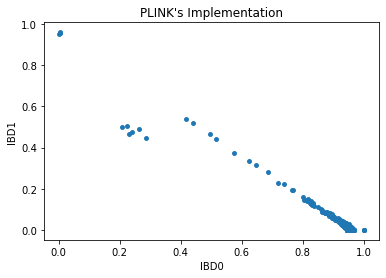

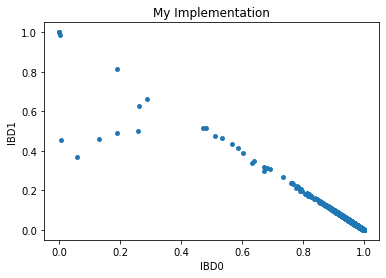

In [5]:
%pylab inline

# Plot IBD=0 vs IBD=1 for my result and PLINK's result

import matplotlib.pyplot as plt

true_ibd = open("plink.ibd.genome") # PLINK's result
next(true_ibd)  # skip header

IBD0, IBD1 = [], []

for line in true_ibd.readlines():
    row = line.split()
    IBD0.append(float(row[6]))
    IBD1.append(float(row[7]))

plt.figure()
plt.scatter(IBD0, IBD1, s=15)
plt.title("PLINK's Implementation")
plt.xlabel("IBD0")
plt.ylabel("IBD1")
plt.show()

ibd = open("my.ibd.genome") # my result
next(ibd)  # skip header

IBD0, IBD1 = [], []

for line in ibd.readlines():
    row = line.split()
    IBD0.append(float(row[2]))
    IBD1.append(float(row[3]))

plt.figure()
plt.scatter(IBD0, IBD1, s=15)
plt.title("My Implementation")
plt.xlabel("IBD0")
plt.ylabel("IBD1")
plt.show()

In [7]:
%pylab inline

# Calculate MSE for pi, which is P(IBD = 2) + 0.5 * P(IBD = 1),
# between my result and PLINK's result

import numpy as np

plink_ibd = open("plink.ibd.genome")
my_ibd = open("my.ibd.genome")
next(plink_ibd)
next(my_ibd)

plink_pi, my_pi = [], []

for line in plink_ibd.readlines():
    row = line.split()
    plink_pi.append(float(row[9]))

for line in my_ibd.readlines():
    row = line.split()
    my_pi.append(float(row[5]))

MSE = sum(pow((np.array(plink_pi) - np.array(my_pi)), 2)) / len(plink_pi)
print(MSE)

Populating the interactive namespace from numpy and matplotlib
0.0013677202600168427
